# Requirements

In [1]:
import pandas as pd
import numpy as np
import string
import re

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from PIL import Image

from joblib import Parallel, delayed


In [2]:
import multiprocessing
multiprocessing.cpu_count()

16

# Data Import

In [3]:
df = pd.read_csv("openlibrary_works.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4301727 entries, 0 to 4301726
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   title     object
 1   authors   object
 2   covers    object
 3   subjects  object
 4   key       object
dtypes: object(5)
memory usage: 164.1+ MB


In [5]:
df.head()

,title,authors,covers,subjects,key
0,Promettre et écrire,"[""OL3965106A""]",[5420446],"[""History, Ancient"", ""Historiography"", ""Compar...",OL10000120W
1,Fortuny,"[""OL3965405A""]",[3140637],"[""Costume design"", ""Italy"", ""Biography"", ""Fash...",OL10000374W
2,Piercing,"[""OL3966705A""]",[3143297],"[""Body piercing"", ""History .""]",OL10001531W
3,Paradise & More,"[""OL92951A""]",[1591541],"[""Fiction"", ""History""]",OL1000568W
4,Une Ombre Au Tableau,"[""OL3975945A""]",[5204497],"[""Peinture"", ""Romans, nouvelles, etc. pour la ...",OL10009415W


# Subject extraction (EDA)

In [7]:
def extract_subjects(k, row, n_works, collated=True, report_freq=1*10**4):
    """Extracts subjects from the 'subjects' column of 'works' table from Open Libaray dump

    Args:
        k (int): Current row index being processed
        row (pd.DataFrame): Current row being processed
        n_works (int): Number of rows to process
        collated (bool, optional): Extract collated or non-collated subjects (see comments below). Defaults to True.
        report_freq (int, optional): Freqency to print progress {k/n_works}. Defaults to 1*10**4.
    """

    if collated: 
        # === COLLATED ===
        # Preserves multi-word subjects in data
        # e.g. ["Body piercing", "History ."] = ["body-piercing", "history"]

        # convert all to lowercase
        curr_subjects = row["subjects"].lower() 
        # extract all subjects from each subject array (text between "'s)
        curr_subjects = re.findall('"([^"]*)"', curr_subjects)
        # convert to np.array
        curr_subjects = np.array(curr_subjects)

        # remove all punctuation and leading/ trailing whitespaces
        curr_subjects = [
            subj.translate(str.maketrans('', '', string.punctuation))
                .strip()
            for subj in curr_subjects]
        # remove any empty strings
        while("" in curr_subjects): curr_subjects.remove("")
        # replace all spaces with "-"
        curr_subjects = [subj.replace(' ', '-') for subj in curr_subjects]

    else: 
        # === SPLIT === 
        # Splits each subject in data into single words
        # Treats each word in subject field as one subject
        # e.g. ["Body piercing", "History ."] = ["body", "piercing", "history"]

        # convert all to lowercase
        curr_subjects = row["subjects"].lower() 
        # remove all punctuation 
        curr_subjects = row["subjects"].translate(str.maketrans('', '', string.punctuation))
        # split processed subjects string into array of individual words
        curr_subjects = curr_subjects.split()

    # === PROGRESS REPORT === 
    if k % (report_freq) == 0:
        print('{0:-8} / {1:}'.format(k, n_works))

    # === RETURN === 
    return(curr_subjects)


## Non-Truncated

In [8]:
N_WORKS = 50000

print("Beginning subject extraction...")
subjects = Parallel(n_jobs=-1)(
    delayed(extract_subjects)(k, row, N_WORKS) for k, row in df[:N_WORKS].iterrows())
subjects = np.concatenate(subjects, axis=0)
print("Subject extraction complete.")

print("\nSample result:")
subjects[:10]

Beginning subject extraction...
       0 / 50000
   10000 / 50000
   20000 / 50000
   30000 / 50000
   40000 / 50000
Subject extraction complete.

Sample result:


array(['history-ancient', 'historiography', 'comparative-method',
       'ancient-history', 'costume-design', 'italy', 'biography',
       'fashion-designers', 'body-piercing', 'history'], dtype='<U202')

In [6]:
# vars
subjects = []     # array of work subjects (not seperated by work)

print("Beginning subject extraction...")
for k, row in df.iterrows():
    # extract all subjects from each subject array (text between "'s)
    curr_subjects = np.array(re.findall('"([^"]*)"', row["subjects"]))
    subjects = np.append(subjects, curr_subjects)

    if k % (5*10**3) == 0:
        print(k)
    if k > 50000:
        break                                          # sample size
print("Subject extraction complete.")


print("Beginning subject cleaning...")
# convert all to lowercase
subjects = [subj.lower() for subj in subjects]
subjects = [                                                 # remove punctuation specified, all leading and traling spaces
    txt.translate(
        str.maketrans('', '', string.punctuation)
    )
    for txt in subjects
]
while("" in subjects):
    subjects.remove("")                  # remove any empty strings
subjects = [subj.replace(' ', '-')
            for subj in subjects]     # replace all spaces with "-"
# unpack arrays to one string
subjects_str = ' '.join(np.ravel(subjects))
print("Complete.")


Beginning subject extraction...
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
Subject extraction complete.
Beginning subject cleaning...
Complete.


In [7]:
text_file = open("allsubj_notrunc_100ksample.txt", "wt")
n = text_file.write(subjects_str)
text_file.close()


In [31]:
subjects = [subj.strip().replace(' ', '-')
            for subj in subjects]     # replace all spaces with "-"
# unpack arrays to one string
subjects_str = ' '.join(np.ravel(subjects))
print("Complete.")


Complete.


In [40]:
subjects_str[:100]
# subjects[:10]


'history-ancient historiography comparative-method ancient-history costume-design italy biography fas'

##### Word Cloud

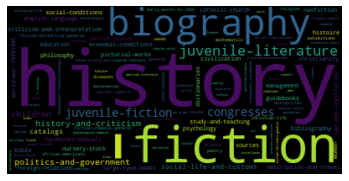

In [47]:
# create the wordcloud object
# https://stackoverflow.com/questions/59148244/keeping-words-together-in-wordcloud

word_could_dict = Counter(subjects)
wordcloud = WordCloud().generate_from_frequencies(word_could_dict)
# wordcloud.to_file("word_test.png")

# plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()


In [49]:
# create a dictionary of word frequencies
sub_dictionary = word_could_dict
# sort the dictionary
word_freq = {k: v for k, v in sorted(
    sub_dictionary.items(), reverse=True, key=lambda item: item[1])}

# use words_ to print relative word frequencies
rel_freq = wordcloud.words_


In [50]:
rel_freq_df = pd.DataFrame.from_dict(
    rel_freq,
    orient='index',
    columns=["Freqency"]
)
rel_freq_df['Subject'] = rel_freq_df.index
rel_freq_df.reset_index(drop=True, inplace=True)
rel_freq_df


,Freqency,Subject
0,1.000000,history
1,0.951280,-
2,0.746161,fiction
3,0.417652,biography
4,0.365049,juvenile-literature
...,...,...
195,0.017123,theater
196,0.017123,biographies
197,0.017123,investigation
198,0.016946,motion-pictures


In [51]:
for hy_word in rel_freq_df["Subject"]:
    if "-" in hy_word:
        print(hy_word)


-
juvenile-literature
juvenile-fiction
politics-and-government
history-and-criticism
social-life-and-customs
description-and-travel
social-conditions
criticism-and-interpretation
united-states
pictorial-works
nursery-stock
handbooks-manuals
economic-conditions
world-war-19391945
english-language
large-type-books
study-and-teaching
foreign-relations
catholic-church
law-and-legislation
fiction-romance-general
fiction-historical-general
case-studies
early-works-to-1800
fiction-general
social-aspects
african-americans
manwoman-relationships
christian-life
indians-of-north-america
economic-policy
psychological-aspects
popular-works
church-history
intellectual-life
ornamental-plants
new-york-times-reviewed
criticism-interpretation
public-health
world-war-19141918
fiction-thrillers-general
religious-aspects
conduct-of-life
american-literature
political-science
english-literature
data-processing
translations-into-english
problems-exercises
fiction-mystery--detective-general
government-policy
n

## Trucated

In [5]:
# Create an array of words in "subjects" column per work:

subjects = []
print("Beginning subject extraction...")
for k, row in df.iterrows():
    curr_subjects = row["subjects"][1:-
                                    1].translate(str.maketrans('', '', string.punctuation))
    subjects.append(curr_subjects)
    if k % (5*10**5) == 0:
        print(k)

print("Subject extraction complete.")
print("Beginning subject concatanation...")
# unpack arrays to one string
subjects_str = ' '.join(np.ravel(subjects))
print("Beginning subject cleaning...")
subjects_str = subjects_str.lower()                    # convert all to lowercase
while("" in subjects_str):
    subjects_str.remove("")    # remove empty strings
# subjects_list = subjects_str.split (" ")               # unpack string to array
print("Complete.")


Beginning subject extraction...
0
500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
Subject extraction complete.


In [ ]:
subjects_str[:1000]


'history ancient historiography comparative method ancient history costume design italy biography fashion designers body piercing history  fiction history peinture romans nouvelles etc pour la jeunesse secret painting fiction secrets amitié surveillance romans filature surveillance furniture design interior decoration criticism and interpretation interior architecture history history politics and government industrial policy economic conditions economic policy history industry and state economische ontwikkeling conditions économiques wirtschaftskrise politique industrielle politique économique wirtschaftsentwicklung soziales system histoire politisches system politique et gouvernement wirtschaftssystem economic history brazil economic conditions female nude in art art themes motives astronomy study and teaching history prosodic analysis linguistics language and emotions german language prosodic analysis energy development energy policy dependency on foreign countries civilization forei

### Word cloud

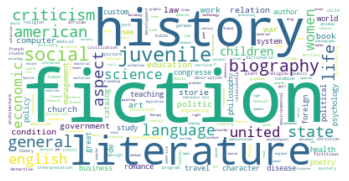

In [22]:
# create the wordcloud object
wordcloud = WordCloud(stopwords=STOPWORDS,
                      collocations=False,
                      background_color="white").generate(subjects_str)

# plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()


In [23]:
# create a dictionary of word frequencies
sub_dictionary = wordcloud.process_text(subjects_str)
# sort the dictionary
word_freq = {k: v for k, v in sorted(
    sub_dictionary.items(), reverse=True, key=lambda item: item[1])}

# use words_ to print relative word frequencies
rel_freq = wordcloud.words_


In [25]:
# print results
print(list(word_freq.items())[:10])
print(list(rel_freq.items())[:10])


[('fiction', 1206031), ('history', 835088), ('literature', 507991), ('juvenile', 383899), ('social', 309844), ('biography', 264952), ('state', 248867), ('american', 244096), ('general', 234565), ('criticism', 226145)]
[('fiction', 1.0), ('history', 0.6924266457495702), ('literature', 0.42120890756539425), ('juvenile', 0.31831603001912884), ('social', 0.2569121357577044), ('biography', 0.21968921196884658), ('state', 0.20635207552708015), ('american', 0.2023961241460626), ('general', 0.1944933422109382), ('criticism', 0.18751176379379966)]


In [64]:
rel_freq_df = pd.DataFrame.from_dict(
    rel_freq,
    orient='index',
    columns=["Freqency"]
)
rel_freq_df['Subject'] = rel_freq_df.index
rel_freq_df.reset_index(drop=True, inplace=True)
rel_freq_df


,Freqency,Subject
0,1.000000,fiction
1,0.692427,history
2,0.421209,literature
3,0.318316,juvenile
4,0.256912,social
...,...,...
195,0.022150,novel
196,0.022042,chemistry
197,0.021950,jewish
198,0.021903,mathematical


### Barcharts

[(0.0, 1.0)]

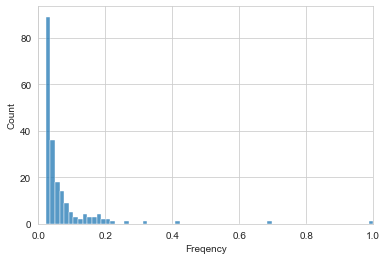

In [65]:
sns.set_style("whitegrid")
sns.histplot(data=rel_freq_df, x="Freqency").set(xlim=(0, 1))


/var/folders/fv/mxpj18zs55g_msjbhknhh0t00000gp/T/ipykernel_60229/3551245842.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


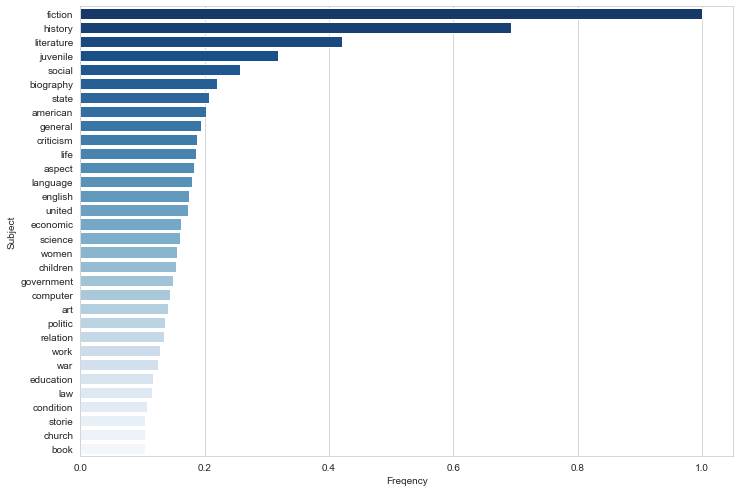

In [79]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.barplot(
    x="Freqency",
    y="Subject",
    data=rel_freq_df[rel_freq_df["Freqency"] > 0.1],
    palette="Blues_r",
    ax=ax
)

fig.show()
